In [1]:
import pandas as pd
import numpy as np
import tensorboard as tb
import seaborn as sns
import time
from datetime import timedelta
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing import event_accumulator as ea
from pathlib import Path

In [2]:
# take every X sample for plot (raw log interval: 20k frames) default: 6
DATA_PLOT_SPARSITY = 100

# rolling average sample window (applied after sparsity) default: 4
DATA_PLOT_SMOOTHNESS = 20

MAX_TRAINING_STEPS = 20000000
# max value of linspace. used to align step values from all seeds and env to be the same. max 
STEP_SPACE_END_VALUE = 20

# in and out dirs
logs_dir = Path("baselines_logs")
variants = ["scobots", "iscobots", "rgb"]
out_dir = Path.cwd() / Path("plots")

# envs to look for in logdir and subdirs and plot
envs = ["Pong", "Boxing", "Tennis", "Bowling", "Skiing", "Freeway", "Kangaroo", "Asterix"]

# experiments to exclude from plots:
dont_plot = []

# scalars to look for in tfevent files and plot
scalars_to_plot = {"rollout/ep_env_rew_mean":
                       {"title" : "Trajectory Return",
                        "xlabel": "Frames (M)",
                        "ylabel": "Score"}}



In [3]:
def time_str(delta):
    x = str(delta).split(":")
    return f"{x[0]}h {x[1]}m {x[2]}s"
    

# for one env
def get_dfs_for_env(env, sca2p, everyx=5, smooth_window=5):
    exp_list = []
    for variant in variants:
        variant_dir = logs_dir / Path(variant)
        for p in variant_dir.rglob("*"):
            if p.is_file():
                if env in str(p.parents[0].name):
                    split_name = p.parents[0].name.split("_")
                    seed = split_name[1][1:]
                    if "rgb" in seed:
                        seed = seed.split("-")[0]
                    exp_name = split_name[0]
                    if p.parents[0].name in dont_plot:
                        continue
                    exp_list.append((seed, p.parents[0]))
    exp_list = set(exp_list) # remove duplicates
    if len(exp_list) == 0:
        return None
    exp_str_list = " ".join([str(n[0]) for n in exp_list])

    # {seed : [(tag, s.step, s.value, seed),...]}
    data_dict = {}
    seed_progress = [[],[],[]]
    for seed, log_dir in exp_list:
        max_step  = 0
        max_wt = 0
        pdir = log_dir.parents[0].name
        if pdir == "scobots":
            scobi_mode = 0
        elif pdir == "iscobots":
            scobi_mode = 1
        else:
            scobi_mode = 2
        for file in log_dir.iterdir():
            if 'tfevents' in file.name:
                acc = ea.EventAccumulator(str(file))
                acc.Reload()
                scalar_list = acc.Tags()['scalars']  
                key = seed + "_" + str(scobi_mode)
                for tag in scalar_list:
                    write_tag = ""
                    if scobi_mode == 2 and tag == "rollout/ep_rew_mean": #rgb seeds log fix
                        write_tag = "rollout/ep_env_rew_mean"
                    if tag == "rollout/ep_env_rew_mean":
                        write_tag = tag
                    if write_tag:
                        for s in acc.Scalars(tag):
                            if not key in data_dict.keys():
                                data_dict[key] = []
                            data_dict[key].append((write_tag, s.step, s.value, seed, scobi_mode, s.wall_time))
                            max_step = s.step if max_step < s.step else max_step
                            max_wt = s.wall_time if max_wt < s.wall_time else max_wt

        seed_progress[scobi_mode].append((seed, (max_step +10000) / MAX_TRAINING_STEPS * 100, max_wt))
    seed_progress[0] = sorted(seed_progress[0], key=lambda x: x[0])
    seed_progress[1] = sorted(seed_progress[1], key=lambda x: x[0])
    seed_progress[2] = sorted(seed_progress[2], key=lambda x: x[0])
    now = time.time()
    
    scobi_seeds_str = "\tscobi\n" + "\n".join([f"\t\t{x}\t{y:.2f}%\t\t{time_str(timedelta(seconds=int(now-z)))} ago" for x, y, z in seed_progress[0]])
    iscobi_seeds_str = "\tiscobi\n" + "\n".join([f"\t\t{x}\t{y:.2f}%\t\t{time_str(timedelta(seconds=int(now-z)))} ago" for x, y, z in seed_progress[1]])
    rgb_seeds_str = "\trgb\n" + "\n".join([f"\t\t{x}\t{y:.2f}%\t\t{time_str(timedelta(seconds=int(now-z)))} ago" for x, y, z in seed_progress[2]])
    
    print(f"{env}")
    print(scobi_seeds_str)
    print(iscobi_seeds_str)
    print(rgb_seeds_str)
    # \t|\tSeeds: scobi: {scobi_seeds_str} \tiscobi: {iscobi_seeds_str}")
    # extracts scalar samples from df,
    # processes them (skipping and smoothing)
    # and appends them to dict value : {scalar_name : [scalar_df, ..]}
    def scalars_to_df(df, scalars, out_df_dict):
        for s in scalars:
            scalar_df = df[df["tag"] == s].copy()
            scalar_df = scalar_df.sort_values(by=["step"], ascending=True)
            scalar_df = scalar_df.drop_duplicates(subset=['step'], keep="last")
            scalar_df = scalar_df.iloc[::everyx, :]
            scalar_df["value"] = scalar_df.value.rolling(smooth_window, min_periods=1).mean()
            step_space = np.linspace(0, STEP_SPACE_END_VALUE, len(scalar_df.index))
            scalar_df["step"] = step_space
            if s in out_df_dict.keys():
                out_df_dict[s].append(scalar_df)
            else:
                out_df_dict[s] = [scalar_df]
    
    scalar_dict = {}    
    # {scalar_name : [scalar_df_seedX, ..],
    #  scalar_name2 : [scalar_df_seedX, ..]}
    for k, v in data_dict.items():
        df = pd.DataFrame(v, columns=["tag", "step", "value", "seed", "scobi_mode", "wall_time"])
        df.step = df.step / 1000000
        scalars_to_df(df, sca2p, scalar_dict)

    # merge seed df's of one scalar to one df, inplace
    scalar_dict.update((k, pd.concat(v, ignore_index=True)) for k, v in scalar_dict.items())
    return scalar_dict

In [4]:
data_to_plot = {}

# goes over every specified env and
# creates dict: {env : {scalar1 : df, scalar2 : df, ...}, env2 : {scalar1 : df, scalar2 :df, ...}, ...}
print("env\tmode\tseed\tprogress\tlast log update")
for e in envs:
    res_dict = get_dfs_for_env(e, scalars_to_plot.keys(), DATA_PLOT_SPARSITY, DATA_PLOT_SMOOTHNESS)
    if res_dict:
        data_to_plot[e] = res_dict
np.save('curve_data_to_plot.npy', data_to_plot) 

env	mode	seed	progress	last log update
Pong
	scobi
		0	100.05%		34 days, 7h 42m 14s ago
		16	100.05%		34 days, 7h 27m 07s ago
		32	100.05%		34 days, 7h 34m 42s ago
	iscobi
		0	100.05%		34 days, 7h 22m 16s ago
		16	100.05%		34 days, 7h 42m 38s ago
		32	100.05%		34 days, 7h 28m 38s ago
	rgb
		0	100.05%		48 days, 18h 58m 18s ago
		16	100.05%		48 days, 19h 02m 45s ago
		32	100.05%		48 days, 18h 53m 00s ago
Boxing
	scobi
		0	100.05%		34 days, 7h 39m 05s ago
		16	100.05%		34 days, 7h 54m 03s ago
		32	100.05%		34 days, 7h 45m 22s ago
	iscobi
		0	100.05%		34 days, 8h 01m 20s ago
		16	100.05%		34 days, 8h 00m 19s ago
		32	100.05%		34 days, 7h 50m 44s ago
	rgb
		0	100.05%		48 days, 18h 02m 13s ago
		16	100.05%		48 days, 18h 08m 50s ago
		32	100.05%		48 days, 18h 11m 44s ago
Tennis
	scobi
		0	100.05%		34 days, 6h 18m 27s ago
		16	100.05%		34 days, 6h 07m 29s ago
		32	100.05%		34 days, 6h 09m 45s ago
	iscobi
		0	100.05%		34 days, 6h 12m 25s ago
		16	100.05%		34 days, 6h 13m 57s ago
		32	100.05%		3

In [5]:
data_to_plot = np.load('curve_data_to_plot.npy',allow_pickle='TRUE').item()

#tdf = data_to_plot["Kangaroo"]['rollout/ep_env_rew_mean']
#tdf.sort_values(by=["step"], ascending=True).head(50)

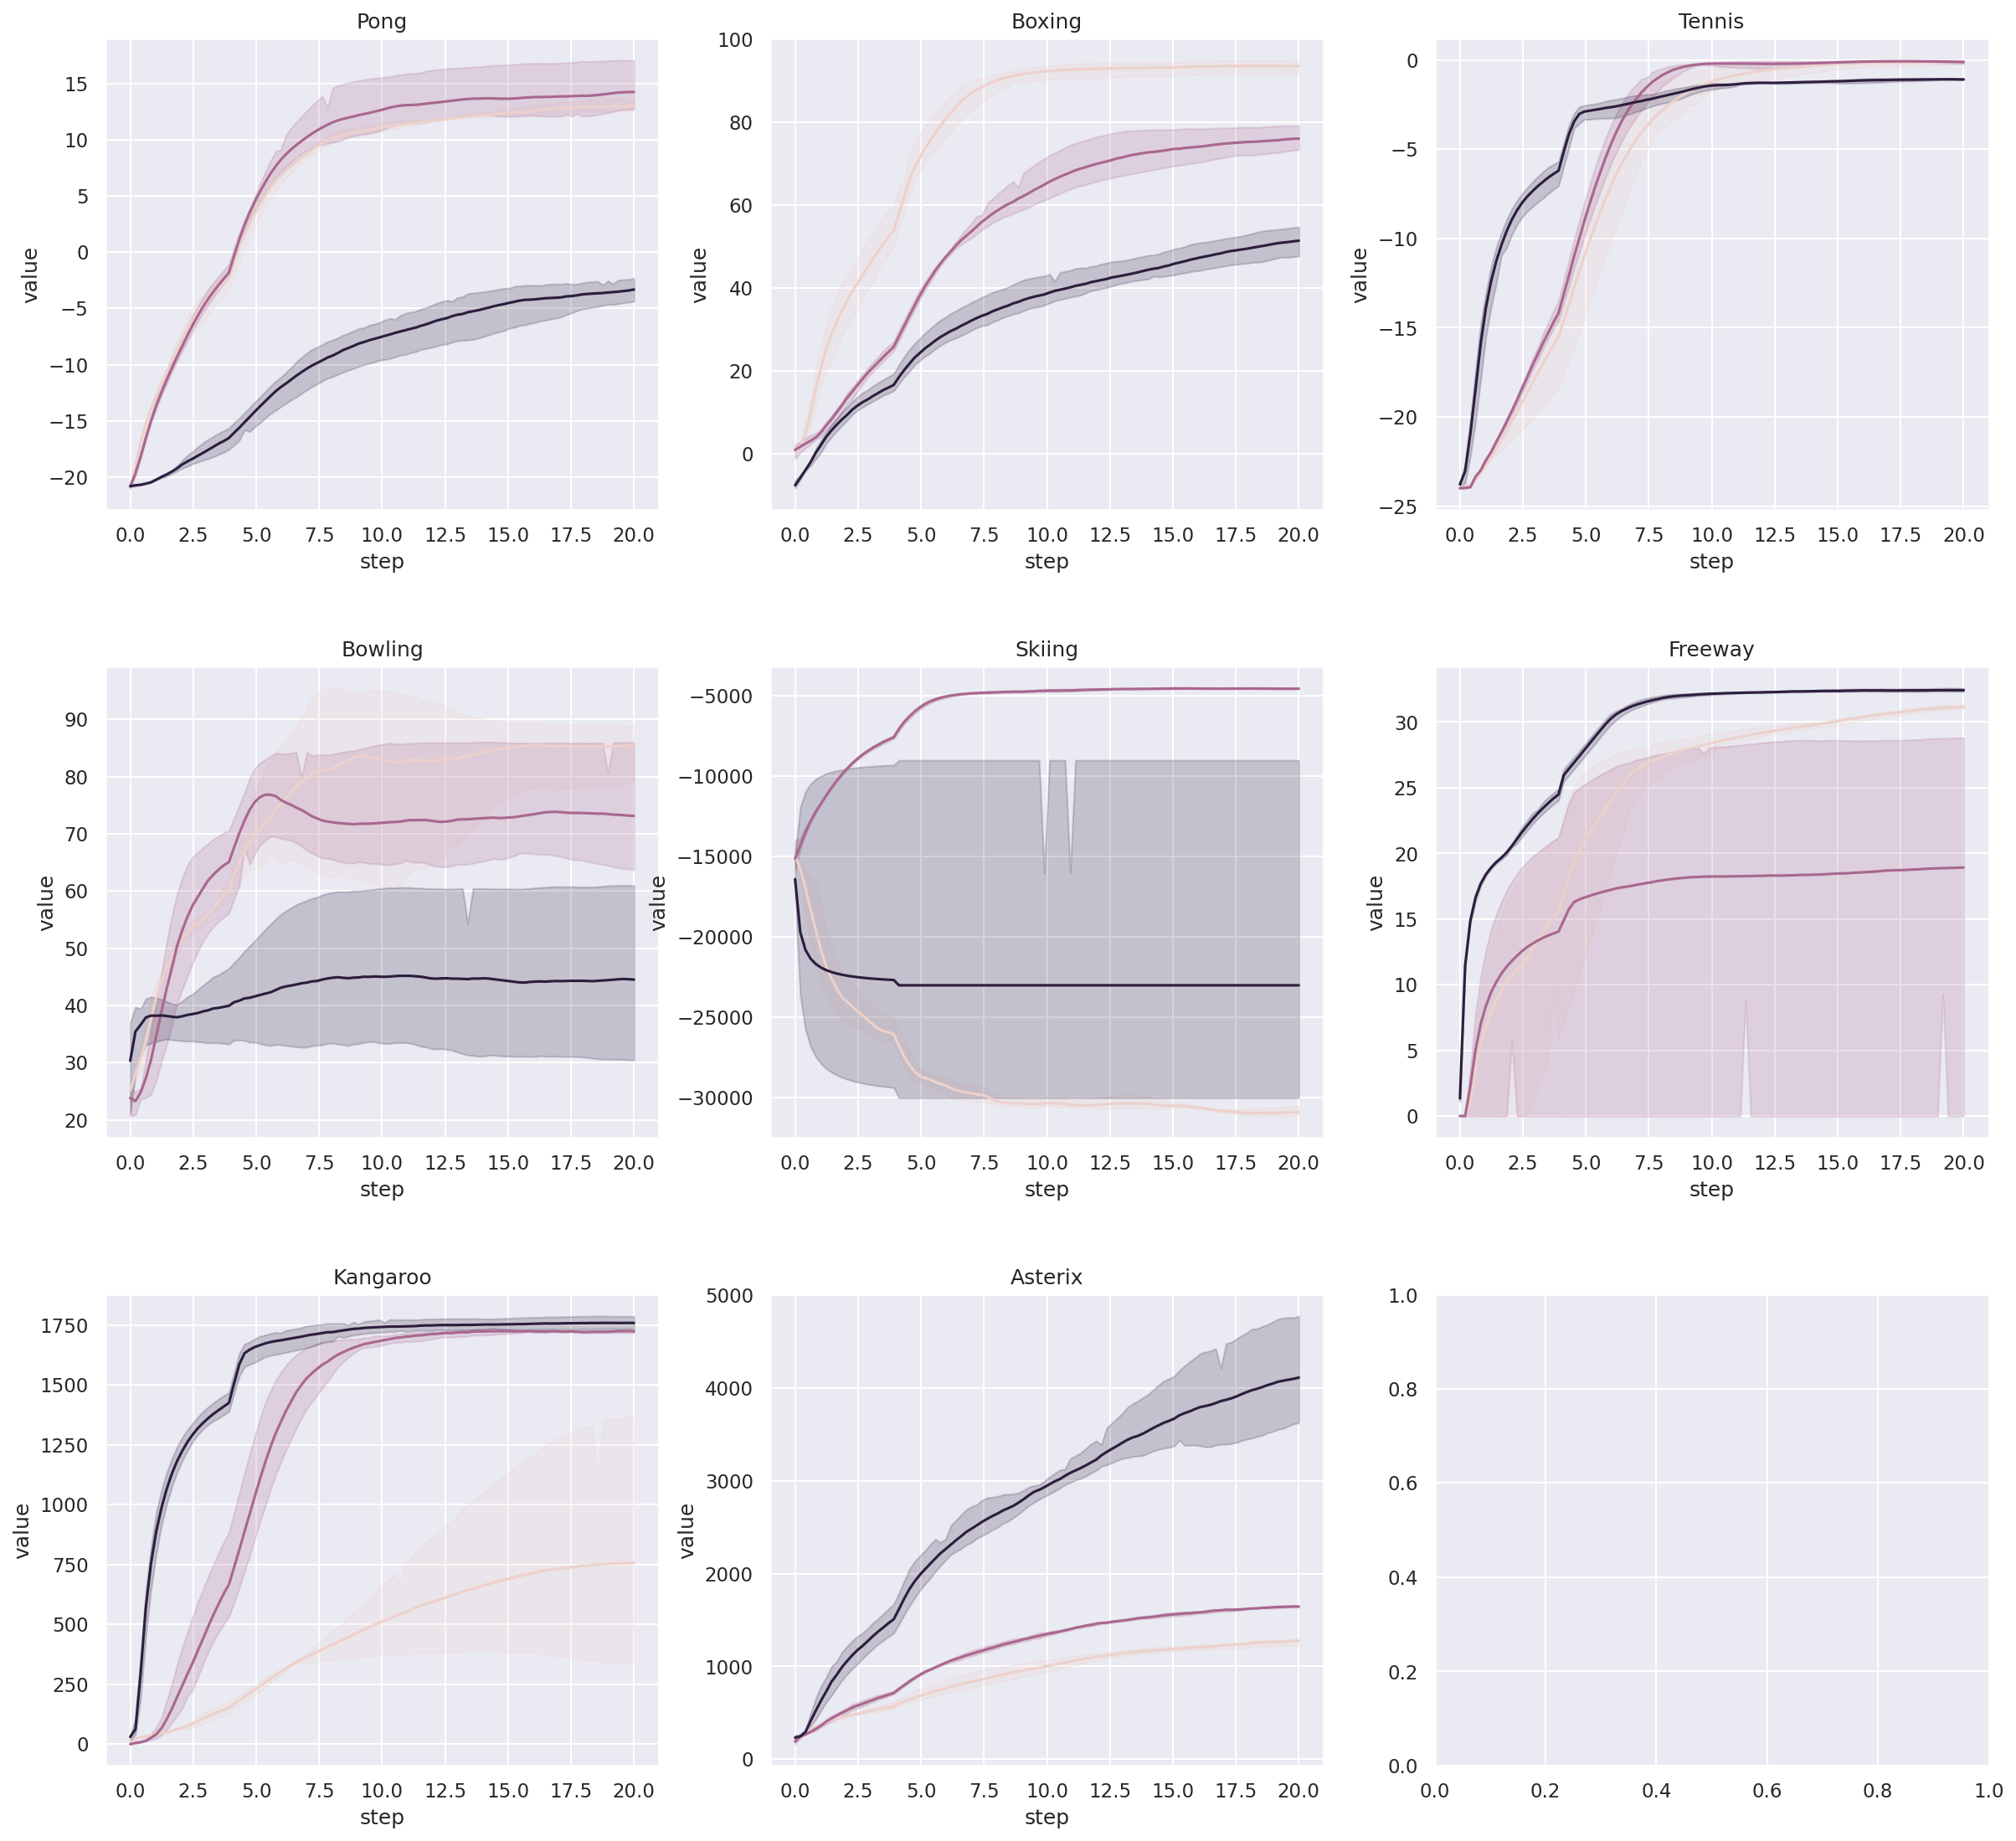

In [11]:
sns.set_theme()
fig_width = 15
no_envs = len(data_to_plot)
width_per_plot = fig_width / 3
fig_size = (fig_width, 3 * width_per_plot)
fig = plt.figure(figsize=fig_size, dpi=150)
subfigs = fig.subfigures(3, 1)
row = -1
axes = None
# env interator
for i, (k, v) in enumerate(data_to_plot.items()):
    col = i % 3
    if col == 0:
        row += 1
        axes = subfigs[row].subplots(1, 3)

    #subfigs[row].suptitle(str(k), fontsize=22, y=1)
    #print(v["rollout/ep_env_rew_mean"].sort_values(by="step").tail(20))
    order = sorted(v["rollout/ep_env_rew_mean"]["scobi_mode"].unique())
    s_plt = sns.lineplot(data=v["rollout/ep_env_rew_mean"], x="step", y="value", hue="scobi_mode", hue_order=order, ax=axes[col])
    axes[col].get_legend().remove()
    s_plt.set(
        #xlabel = s_descriptions["xlabel"],
        #ylabel = s_descriptions["ylabel"],
        title  = k)

plt.subplots_adjust(top = 0.9, bottom=0.15, left=0, right=1)
plt.show(fig)
fig.savefig(out_dir / "results.png", bbox_inches='tight')
fig.savefig(out_dir / "results.pdf", bbox_inches='tight')
fig.savefig(out_dir / "results.svg", bbox_inches='tight')